In [137]:
import os
import glob
import json

import pandas as pd
import numpy as np
import pylab as pl
import cPickle as pkl
import seaborn as sns

from pipeline.python.utils import natural_keys, label_figure

In [3]:
%matplotlib inline

#### Set data source:

In [4]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'CE077'
session = '20180521'
fov = 'FOV2'
run = 'blobs_dynamic_run1'
traceid = 'traces002'


In [7]:
traceid_dir = glob.glob(os.path.join(rootdir, animalid, session, '%s*' % fov, run, 'traces', '%s*' % traceid))[0]
data_fpath = os.path.join(traceid_dir, 'data_arrays', 'datasets.npz')

#### Load data array

In [9]:
df = np.load(data_fpath)
print df.keys()

['F0', 'labels_data', 'zscore', 'meanstimdff', 'frac', 'tsecs', 'quantile', 'corrected', 'ylabels', 'smoothedX', 'labels_columns', 'sconfigs', 'raw', 'run_info', 'groups', 'meanstim', 'dff', 'smoothedDF']


In [10]:
labels = pd.DataFrame(data=df['labels_data'], columns=df['labels_columns'])
print labels.head()

  nframes_on stim_on_frame     config stim_dur       trial      tsec
0         89            45  config040        2  trial00001  -1.00758
1         89            45  config040        2  trial00001 -0.985188
2         89            45  config040        2  trial00001 -0.962797
3         89            45  config040        2  trial00001 -0.940407
4         89            45  config040        2  trial00001 -0.918016


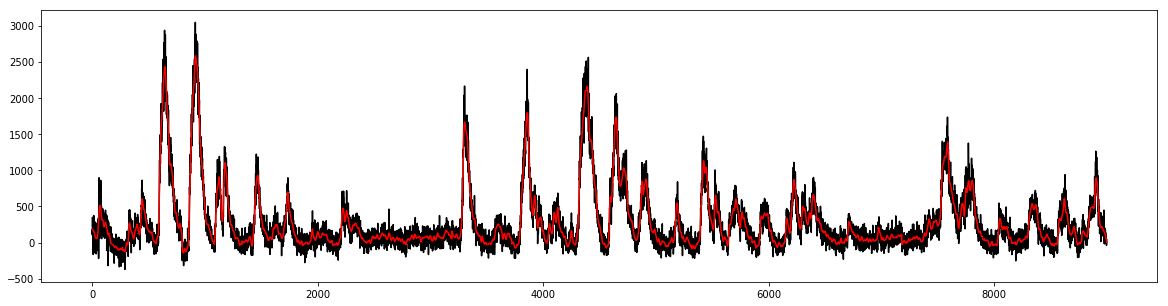

In [16]:
pl.figure(figsize=(20,5))
pl.plot(df['corrected'][0:9000, 0], 'k')
pl.plot(df['smoothedX'][0:9000, 0], 'r')

In [18]:
xdata = df['smoothedX']
print("data:", xdata.shape)
print("labels:", labels.shape)

('data:', (85120, 182))
('labels:', (85120, 6))


#### Get stimulus configs

In [30]:
with open(os.path.join(traceid_dir, 'data_arrays', 'runinfo.pkl'), 'rb') as f:
    info = pkl.load(f)
print info.keys()

sconfigs = info['sconfigs']
sdf = pd.DataFrame(sconfigs).T
print sdf.head()

['sconfigs', 'run_info']
          morphlevel          object size stimtype xpos ypos yrot
config001         11  Blob_M11_Rot_y   45    movie   -5    0   -1
config002         11  Blob_M11_Rot_y   45    movie  -15    0   -1
config003         11  Blob_M11_Rot_y   45    movie    0    0   -1
config004         11  Blob_M11_Rot_y   45    movie  -10    0   -1
config005         11  Blob_M11_Rot_y   45    movie    5    0   -1


In [111]:
morph_levels = sdf['morphlevel'].unique()
print morph_levels

[11 -1 0 22]


# Look at 1 movie type

In [114]:
def get_frames_by_config(roi, curr_config, xdata, labels):
    config_frames = labels[labels['config'].isin(curr_config.index.tolist())]
    #config_frames.head()   
    trials = config_frames.groupby('trial')
    trial_data = [pd.Series(xdata[g.index, roi]) for k, g in trials]
    trialdf = pd.concat(trial_data, axis=1)
    return trialdf

In [116]:
def plot_roi_trials(roidata, ax=None, c='k', lw=0.2):
    if ax is None:
        fig, ax = pl.subplots()
        
    for tnum in roidata.columns.tolist():
        if tnum == 'roi':
            continue
        ax.plot(roidata[tnum].values, c=c, lw=lw)


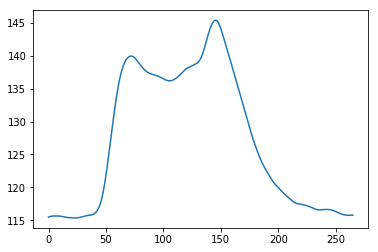

In [175]:
# Get GRAND MEAN (avg trace across all trials)

cfg_all = sdf.copy()
all_trials = labels.groupby('trial')
roidata = []
for roi in range(nrois):
    trialdf = get_frames_by_config(roi, cfg_all, xdata, labels)
    trialdf['roi'] = pd.Series([roi for _ in range(trialdf.shape[0])])
    roidata.append(trialdf)
rdata_all = pd.concat(roidata, axis=0)


trial_cols = [col for col in rdata_all.columns if col != 'roi']
roi_grand_means = pd.concat([pd.Series(all_trials[trial_cols].mean(axis=1)) for roi, all_trials in rdata_all.groupby('roi')], axis=1)
roi_grand_means.head()
roi_grand_means.shape
GM = roi_grand_means.mean(axis=1)
GM.shape
pl.plot(GM)

In [129]:
# morphlevel = -1
# curr_yrot = -1

In [176]:
nrois = xdata.shape[-1]
print nrois


182


In [ ]:
    mean_trace1 = np.mean(roidata1.values, axis=1)
    mean_trace2 = np.mean(roidata2.values, axis=1)

    if plot_raw:
        fig, axes = pl.subplots(1,2)
        plot_roi_trials(roidata1, ax=axes[0], c='k', lw=0.2)
        axes[0].plot(mean_trace1, 'k', lw=1)

        plot_roi_trials(roidata2, ax=axes[1], c='k', lw=0.2)
        axes[1].plot(mean_trace2, 'k', lw=1)


### Split by direction

In [191]:

dir1 = -1
dir2 = 1

rdata_by_morph =  dict((morph_level, {}) for morph_level in morph_levels)

for morph_level in morph_levels:
    
    cfg1 = sdf[(sdf['morphlevel']==morph_level) & (sdf['yrot']==dir1)]
    cfg2 = sdf[(sdf['morphlevel']==morph_level) & (sdf['yrot']==dir2)]

    roidata = []
    for roi in range(nrois):
        trialdf = get_frames_by_config(roi, cfg1, xdata, labels)
        trialdf['roi'] = pd.Series([roi for _ in range(trialdf.shape[0])])
        roidata.append(trialdf)
    rdata1 = pd.concat(roidata, axis=0)
    print rdata1.shape

    roidata = []
    for roi in range(nrois):
        trialdf = get_frames_by_config(roi, cfg2, xdata, labels)
        trialdf['roi'] = pd.Series([roi for _ in range(trialdf.shape[0])])
        roidata.append(trialdf)
    rdata2 = pd.concat(roidata, axis=0)
    
    rdata_by_morph[morph_level][dir1] = rdata1
    rdata_by_morph[morph_level][dir2] = rdata2

    

(48412, 41)
(48412, 41)
(48412, 41)
(48412, 41)


In [198]:
trial_cols = [col for col in rdata1 if col != 'roi']
rdata1[trial_cols].head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,534.322823,-9.685353,20.402072,-77.780478,56.344407,-39.162441,6.491763,-26.819323,275.507496,-50.739864,...,31.808784,9.910424,168.447872,135.230836,164.506837,-5.641343,171.552555,-57.339130,-14.908649,-67.309531
1,536.879743,-15.459205,19.991059,-80.977771,58.724911,-42.335784,-0.130664,-27.052768,277.369111,-46.921363,...,29.547484,4.655851,165.325712,134.873642,166.805880,-5.888019,162.981174,-56.937819,-14.440677,-65.225582
2,537.972324,-20.468583,20.148981,-84.088909,60.377313,-45.312343,-5.631899,-26.388981,279.148529,-43.048183,...,26.636818,-2.104244,161.610327,135.165480,167.906605,-5.272151,154.908198,-56.142546,-14.142533,-63.461211
3,538.128287,-25.257163,20.986440,-86.734981,60.745500,-47.680145,-9.432081,-26.086973,278.919536,-39.718782,...,22.899313,-9.704972,157.772211,134.823542,167.909431,-4.237309,148.671380,-55.198185,-13.625870,-62.805053
4,538.196210,-30.029965,21.781533,-87.802666,59.285696,-48.381067,-11.729083,-26.862602,275.909910,-37.048488,...,17.900547,-16.944578,153.824664,131.962076,166.751503,-3.548808,144.496117,-53.942399,-13.233104,-63.605392


#### Plot popN trace of each condition, subtract condition mean (within morph)

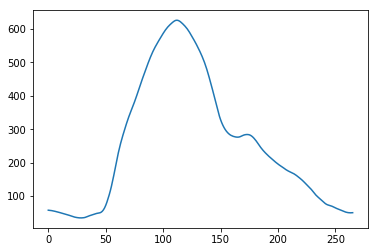

In [211]:

grps1 = rdata_by_morph[morph_level][dir1].groupby('roi')
mean_roi_traces = pd.concat([ pd.Series(grp[trial_cols].mean(axis=1), name=roi) for roi, grp in grps1 ], axis=1)
mean_roi_traces.head()
pl.plot(mean_roi_traces[0])

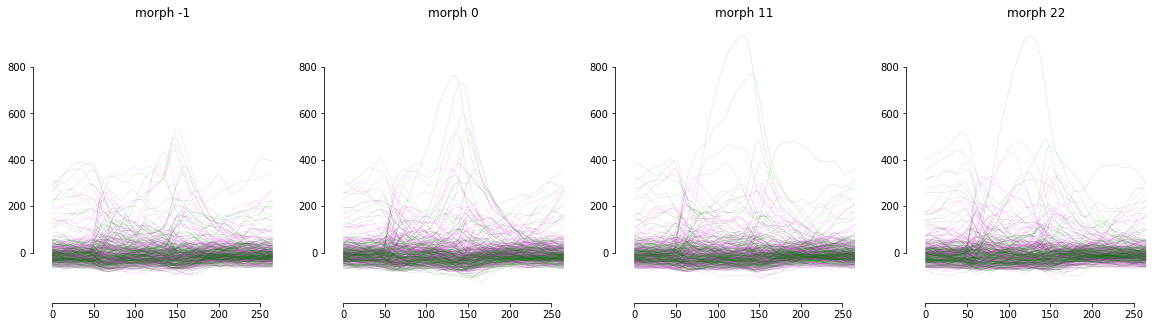

In [230]:
# Plot each roi's mean trace, subtracted by condition mean:

plot_raw = False
dir1_color = 'magenta'
dir2_color = 'green'
dir1_label = 'dir %i' % dir1
dir2_label = 'dir %i' % dir2
    
fig, axes = pl.subplots(1, len(morph_levels), figsize=(20, 5), sharey=True)
for mi, morph_level in enumerate(sorted(morph_levels)):

    ax = axes[mi]
    
    grps1 = rdata_by_morph[morph_level][dir1].groupby('roi')
    mean_roi_traces1 = pd.concat([ pd.Series(grp[trial_cols].mean(axis=1), name=roi) for roi, grp in grps1 ], axis=1)

    grps2 = rdata_by_morph[morph_level][dir2].groupby('roi')
    mean_roi_traces2 = pd.concat([ pd.Series(grp[trial_cols].mean(axis=1), name=roi) for roi, grp in grps2 ], axis=1)
    
    
    #roidata1 = rdata_by_morph[morph_level][dir1][trial_cols]
    #roidata2 = rdata_by_morph[morph_level][dir2][trial_cols]
    #roidata1 = rdata1[rdata1['roi']==0]
    #roidata2 = rdata2[rdata2['roi']==0]
    popn_trace1 = mean_roi_traces1.mean(axis=1)
    popn_trace2 = mean_roi_traces2.mean(axis=1)

    mean_ppn_trace = (popn_trace1 + popn_trace2) / 2.

    # fig, ax = pl.subplots()
    meansub1 = []
    for roi in mean_roi_traces1.columns.tolist():
        values = mean_roi_traces1[roi] - mean_ppn_trace
        ax.plot(values, c=dir1_color, lw=0.1)
        meansub1.append(values)

    grand_mean1 = np.mean(np.array(meansub1), axis=0)
    #ax.plot(grandmean1, c=dir1_color, lw=2, label=dir1_label)

    
    
    meansub2 = []
    for roi in mean_roi_traces2.columns.tolist():
        values = mean_roi_traces2[roi] - mean_ppn_trace
        ax.plot(values, c=dir2_color, lw=0.1)
        meansub2.append(values)

    grand_mean2 = np.mean(np.array(meansub2), axis=0)
    #ax.plot(grand_mean2, c=dir2_color, lw=2, label=dir2_label)
    
    ax.set_title('morph %i' % morph_level)

sns.despine(trim=True, offset=8)
    

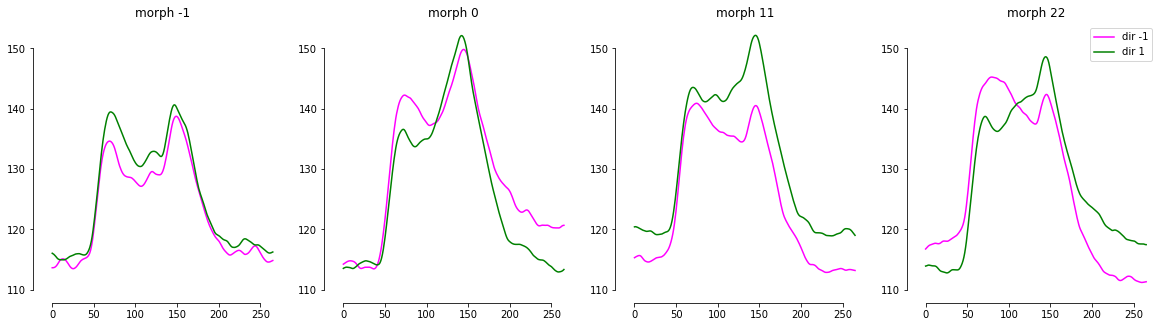

In [242]:

plot_raw = False
dir1_color = 'magenta'
dir2_color = 'green'
dir1_label = 'dir %i' % dir1
dir2_label = 'dir %i' % dir2

popn_traces = dict((morph_level, {}) for morph_level in morph_levels)
fig, axes = pl.subplots(1, len(morph_levels), figsize=(20, 5), sharey=True)
for mi, morph_level in enumerate(sorted(morph_levels)):

    ax = axes[mi]
    
    grps1 = rdata_by_morph[morph_level][dir1].groupby('roi')
    mean_roi_traces1 = pd.concat([ pd.Series(grp[trial_cols].mean(axis=1), name=roi) for roi, grp in grps1 ], axis=1)

    grps2 = rdata_by_morph[morph_level][dir2].groupby('roi')
    mean_roi_traces2 = pd.concat([ pd.Series(grp[trial_cols].mean(axis=1), name=roi) for roi, grp in grps2 ], axis=1)

    popn_trace1 = mean_roi_traces1.mean(axis=1)
    popn_trace2 = mean_roi_traces2.mean(axis=1)
    
    popn_traces[morph_level][dir1] = popn_trace1
    popn_traces[morph_level][dir2] = popn_trace2

    mean_ppn_trace = (popn_trace1 + popn_trace2) / 2.
    
    ax.plot(popn_trace1, c=dir1_color, label=dir1_label)
    ax.plot(popn_trace2, c=dir2_color, label=dir2_label)
    #ax.plot(mean_ppn_trace, 'k')

    ax.set_title('morph %i' % morph_level)

sns.despine(trim=True, offset=8)
ax.legend()

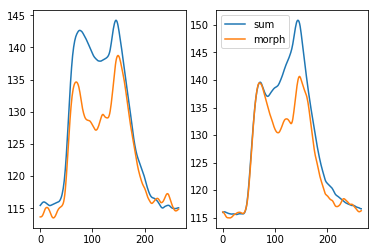

In [248]:
fig, axes = pl.subplots(1,2)

rotation_mean1 = np.mean([popn_traces[m][dir1] for m in [0, 11, 22]], axis=0)
axes[0].plot(rotation_mean1, label='sum')
axes[0].plot(popn_traces[-1][dir1], label='morph')

rotation_mean2 = np.mean([popn_traces[m][dir2] for m in [0, 11, 22]], axis=0)
axes[1].plot(rotation_mean2, label='sum')
axes[1].plot(popn_traces[-1][dir2], label='morph')

axes[1].legend()

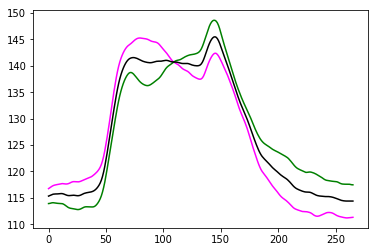

In [231]:
pl.plot(popn_trace1, c=dir1_color)
pl.plot(popn_trace2, c=dir2_color)
pl.plot(mean_ppn_trace, 'k')

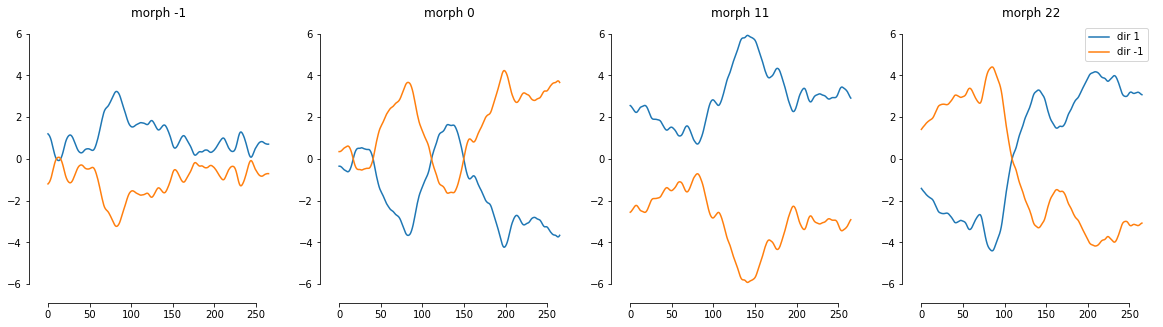

In [249]:

plot_raw = False
dir1_color = 'magenta'
dir2_color = 'green'
dir1_label = 'dir %i' % dir1
dir2_label = 'dir %i' % dir2
    
fig, axes = pl.subplots(1, len(morph_levels), figsize=(20, 5), sharey=True)
for mi, morph_level in enumerate(sorted(morph_levels)):

    ax = axes[mi]
    
    grps1 = rdata_by_morph[morph_level][dir1].groupby('roi')
    mean_roi_traces1 = pd.concat([ pd.Series(grp[trial_cols].mean(axis=1), name=roi) for roi, grp in grps1 ], axis=1)

    grps2 = rdata_by_morph[morph_level][dir2].groupby('roi')
    mean_roi_traces2 = pd.concat([ pd.Series(grp[trial_cols].mean(axis=1), name=roi) for roi, grp in grps2 ], axis=1)

    popn_trace1 = mean_roi_traces1.mean(axis=1)
    popn_trace2 = mean_roi_traces2.mean(axis=1)

    mean_ppn_trace = (popn_trace1 + popn_trace2) / 2.

    meansub1 = []
    for roi in mean_roi_traces1.columns.tolist():
        values = mean_roi_traces1[roi] - mean_ppn_trace
        meansub1.append(values)

    grand_mean1 = np.mean(np.array(meansub1), axis=0)

    meansub2 = []
    for roi in mean_roi_traces2.columns.tolist():
        values = mean_roi_traces2[roi] - mean_ppn_trace
        meansub2.append(values)

    grand_mean2 = np.mean(np.array(meansub2), axis=0)
    
    ax.plot(grand_mean2, label=dir2_label)
    ax.plot(grand_mean1, label=dir1_label)
    
    ax.set_title('morph %i' % morph_level)

sns.despine(trim=True, offset=8)
ax.legend()
    

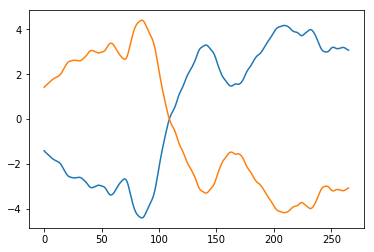

In [226]:
mean_roi_traces1[0].shape
grand_mean1.shape
pl.plot(grand_mean2)
pl.plot(grand_mean1)


In [255]:
labels.columns.tolist()

['nframes_on', 'stim_on_frame', 'config', 'stim_dur', 'trial', 'tsec']

In [ ]:
def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Sample name')

Text(0.5,59.875,u'time')

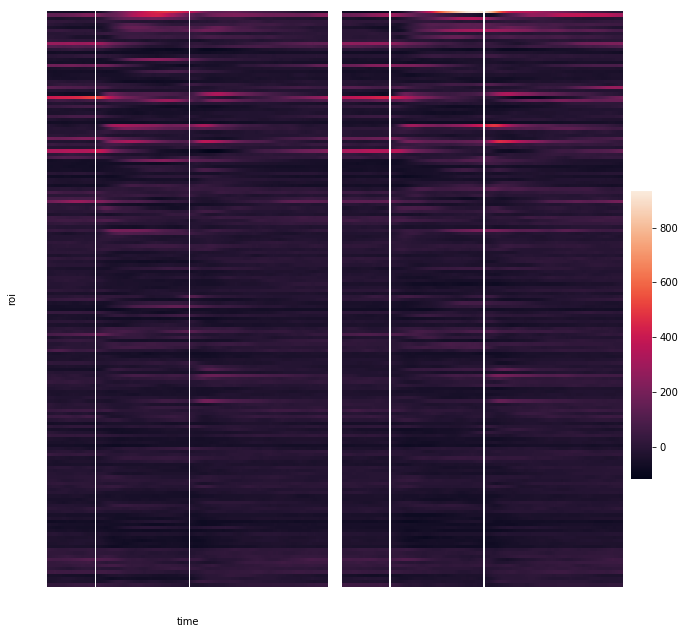

In [333]:
stim_on = list(set(labels['stim_on_frame']))[0]
nframes_on = list(set(labels['nframes_on']))[0]

fig, axes = pl.subplots(1,2, sharex=True, sharey=True, frameon=False, figsize=(10,10))


meansub1 = np.array(meansub1)
meansub2 = np.array(meansub2)

# sns.heatmap(meansub1, ax=axes[0])
# sns.heatmap(meansub2, ax=axes[1])
cbar_ax = fig.add_axes([.91, .3, .03, .4])

meansubs = [meansub1, meansub2]
vmax = np.max((meansub1.max(), meansub2.max()))
vmin = np.min((meansub1.min(), meansub2.min()))

for ai, ax in enumerate(axes.flat):
    sns.heatmap(meansubs[ai], ax=ax,
                cbar=ai == 0,
                vmin=vmin, vmax=vmax,
                cbar_ax=None if ai else cbar_ax)
            

for tepoch in [stim_on, stim_on+nframes_on]:
    axes[0].axvline(tepoch, color='w', lw=1)
    axes[1].axvline(tepoch, color='w', lw=2)
    axes[0].tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    axes[1].tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')

pl.subplots_adjust(bottom=0.15, top=0.95, wspace=0.05, left=0.1)

axes[0].set_ylabel('roi')
axes[0].set_xlabel('time')


# PCA

In [480]:
from sklearn.decomposition import PCA


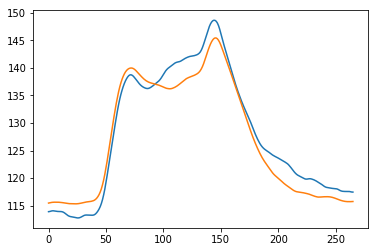

In [405]:
grand_mean = mean_roi_traces.mean(axis=1)
pl.plot(grand_mean)
pl.plot(GM)

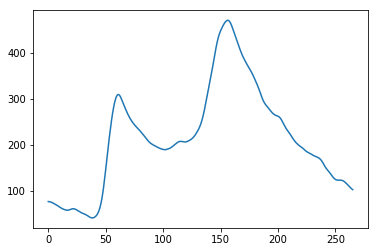

In [411]:
meansub = mean_roi_traces.sub(GM, axis='columns')
pl.plot(mean_roi_traces[26])

In [447]:
tracemat_df = pd.concat([tracemat, pd.Series(tracemat_labels, name='label', index=tracemat.index)], axis=1)
#tracemat_df.head()
print nrois

gmean_trace_by_roi = np.empty((nframes_per_trial, nrois))
index_grps = tracemat_df.groupby(level=0)
for k, g in index_grps:
    gmean_trace_by_roi[k, :] = g.mean(axis=0)
    

182


In [444]:
1596/266.

6.0

In [429]:
g.mean(axis=0).shape

(182,)

#### Create separate subset of data to fit PCA

In [977]:
subtract_grandmean = True
fit_different = True

pca_morph_levels = [-1]

pcafit_tracemat_list = []
pcafit_tracemat_labels = []
for morph_level in pca_morph_levels: #[0, 11, 22]:

    for direction in [dir1, dir2]:
        grps = rdata_by_morph[morph_level][direction].groupby('roi')
        mean_roi_traces_by_cond = pd.concat([ pd.Series(grp[trial_cols].mean(axis=1), name=roi) for roi, grp in grps ], axis=1)
        
        if subtract_grandmean:
            cond_tracemat = mean_roi_traces_by_cond - gmean_trace_by_roi
        else:
            cond_tracemat = mean_roi_traces_by_cond.copy()
            
        pcafit_tracemat_list.append(cond_tracemat)
        pcafit_tracemat_labels.extend(['%i_%i' % (morph_level, direction) for _ in range(mean_roi_traces.shape[0])])
        

pca_tracemat = pd.concat(pcafit_tracemat_list, axis=0)
print pca_tracemat.shape

(532, 182)


###### ... or, fit all data for PCA

In [978]:
subtract_grandmean = True
curr_morph_levels = [-1, 0, 11, 22]

tracemat_list = []
tracemat_labels = []
for morph_level in curr_morph_levels: #[0, 11, 22]:

    for direction in [dir1, dir2]:
        grps = rdata_by_morph[morph_level][direction].groupby('roi')
        mean_roi_traces_by_cond = pd.concat([ pd.Series(grp[trial_cols].mean(axis=1), name=roi) for roi, grp in grps ], axis=1)
        
        if subtract_grandmean:
            cond_tracemat = mean_roi_traces_by_cond - gmean_trace_by_roi
        else:
            cond_tracemat = mean_roi_traces_by_cond.copy()
            
        tracemat_list.append(cond_tracemat)
        tracemat_labels.extend(['%i_%i' % (morph_level, direction) for _ in range(mean_roi_traces.shape[0])])
        

tracemat = pd.concat(tracemat_list, axis=0)
print tracemat.shape

(2128, 182)


In [979]:
ncomps = 2
pca = PCA(n_components=ncomps)

if fit_different:
    pca.fit(pca_tracemat)
else:
    pca.fit(tracemat)

In [980]:
# ncomps = 2

# pca = PCA(n_components=ncomps)
# pca.fit(tracemat)

# pcomponents = pca.fit_transform(tracemat)
pcomponents = pca.transform(tracemat)

pca_data = pd.DataFrame(data=pcomponents,
                      columns=['pc%i' % int(i+1) for i in range(ncomps)])

pca_labels = pd.DataFrame(data=tracemat_labels,
                         columns=['target'])

pca_df = pd.concat([pca_data, pca_labels], axis=1).reset_index()
pca_df.shape
pca_df.head()

,index,pc1,pc2,target
0,0,-216.046703,18.093668,-1_-1
1,1,-215.913487,15.373818,-1_-1
2,2,-215.816898,12.846933,-1_-1
3,3,-215.823012,10.445369,-1_-1
4,4,-215.962932,8.220441,-1_-1


In [981]:
# Set color maps and labels:
print curr_morph_levels
target_labels = list(set(tracemat_labels))
morph_colors = sns.cubehelix_palette(len(curr_morph_levels))
cmapping = dict((ml, morph_colors[mi]) for mi, ml in enumerate(sorted(curr_morph_levels)))
    

[-1, 0, 11, 22]


In [982]:
pgroups = pca_df.groupby('target')
nframes_per_trial = pgroups.get_group(target_labels[0]).shape[0]
print nframes_per_trial

266


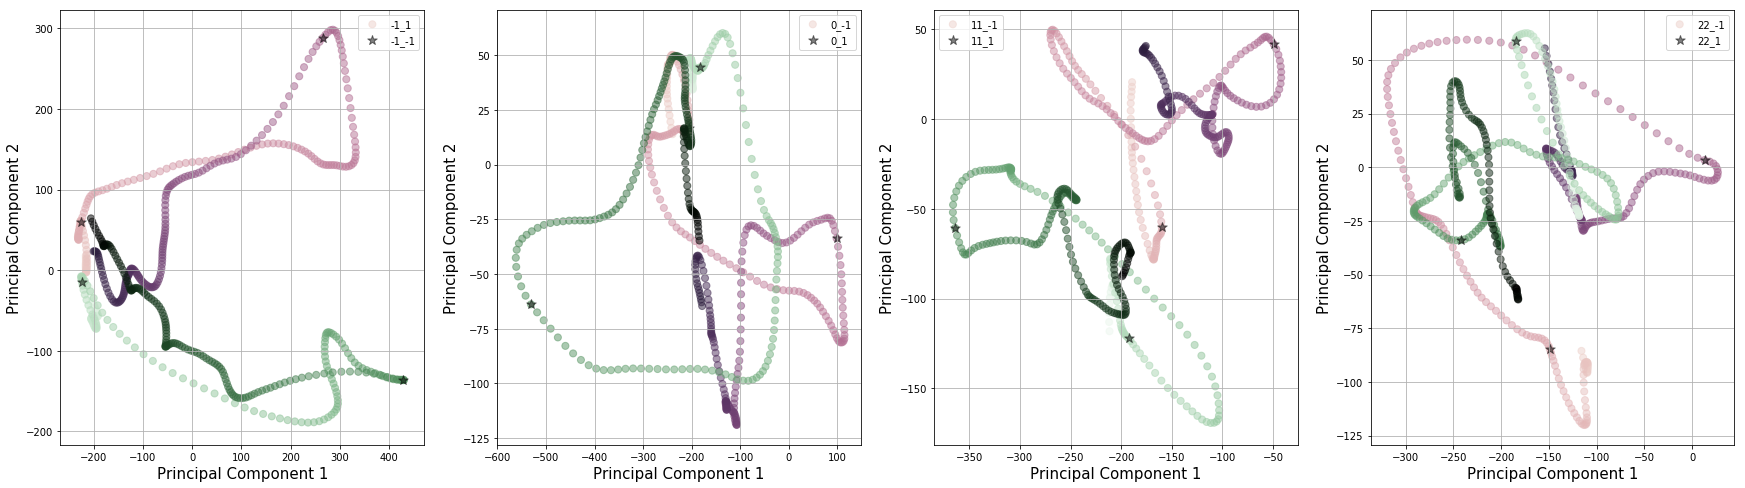

In [983]:

# Visualize 2D projection:
fig, axes = pl.subplots(1, len(curr_morph_levels), figsize = (30,8))
curr_morph_levels

for mi, morph_level in enumerate(sorted(curr_morph_levels)):

    ax = axes[mi] #fig.add_subplot(1,1,1)
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    #ax.set_title('PCA-reduced k-D neural state for each tpoint', fontsize = 20)
    #for target, color in zip(orientations,colors):

    labels_to_plot = [t for t in target_labels if int(t.split('_')[0]) == morph_level]

    #color_tseries = sns.color_palette("cubehelix", nframes_per_trial)
    color_tseries1 = sns.cubehelix_palette(nframes_per_trial)
    color_tseries2 = sns.cubehelix_palette(nframes_per_trial, start=2, rot=0, dark=0, light=0.95, reverse=False)

    for tindex, target_label in enumerate(sorted(labels_to_plot)):

        numeric_ml = int(target_label.split('_')[0])
        numeric_dir = int(target_label.split('_')[1])

        if numeric_dir == dir1:
            curr_colors = color_tseries1
        else:
            curr_colors = color_tseries2

        indicesToKeep = pca_df['target'] == target_label

        ax.scatter(pca_df.loc[indicesToKeep, 'pc1'],
                   pca_df.loc[indicesToKeep, 'pc2'],
                   c = curr_colors, #dir_colors[tindex], #cmapping[numeric_ml],
                   s = 50,
                   alpha=0.5)

        stim_on_ix = pca_df.loc[indicesToKeep, 'pc1'].index.tolist()[stim_on]
        stim_off_ix = pca_df.loc[indicesToKeep, 'pc1'].index.tolist()[stim_on+nframes_on]

        ax.scatter([pca_df.loc[indicesToKeep, 'pc1'][stim_on_ix], pca_df.loc[indicesToKeep, 'pc1'][stim_off_ix]],
                   [pca_df.loc[indicesToKeep, 'pc2'][stim_on_ix], pca_df.loc[indicesToKeep, 'pc2'][stim_off_ix]],
                   c='k', s=100, alpha=0.5, marker="*", label=None)


    ax.legend(labels_to_plot)
    ax.grid()



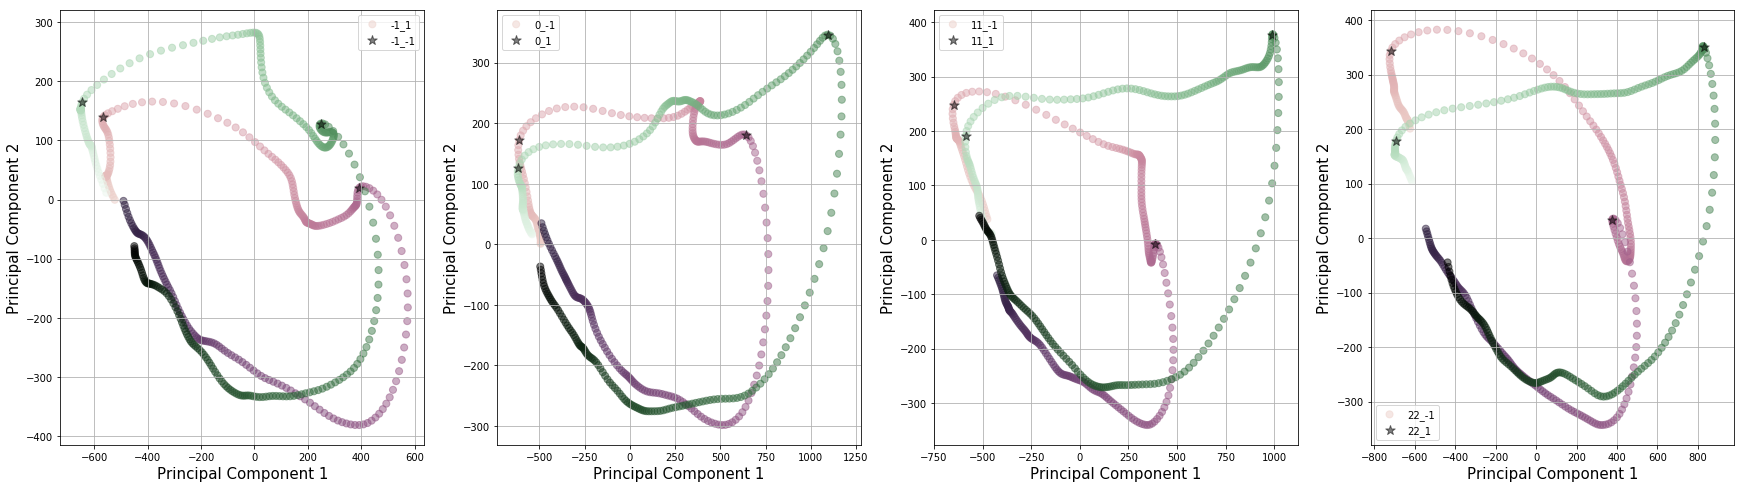

In [490]:
if fit_different is False:
    # Visualize 2D projection:
    fig, axes = pl.subplots(1, len(curr_morph_levels), figsize = (30,8))
    curr_morph_levels

    for mi, morph_level in enumerate(sorted(curr_morph_levels)):

        ax = axes[mi] #fig.add_subplot(1,1,1)
        ax.set_xlabel('Principal Component 1', fontsize = 15)
        ax.set_ylabel('Principal Component 2', fontsize = 15)
        #ax.set_title('PCA-reduced k-D neural state for each tpoint', fontsize = 20)
        #for target, color in zip(orientations,colors):

        labels_to_plot = [t for t in target_labels if int(t.split('_')[0]) == morph_level]

        #color_tseries = sns.color_palette("cubehelix", nframes_per_trial)
        color_tseries1 = sns.cubehelix_palette(nframes_per_trial)
        color_tseries2 = sns.cubehelix_palette(nframes_per_trial, start=2, rot=0, dark=0, light=0.95, reverse=False)

        for tindex, target_label in enumerate(sorted(labels_to_plot)):

            numeric_ml = int(target_label.split('_')[0])
            numeric_dir = int(target_label.split('_')[1])

            if numeric_dir == dir1:
                curr_colors = color_tseries1
            else:
                curr_colors = color_tseries2

            indicesToKeep = pca_df['target'] == target_label

            ax.scatter(pca_df.loc[indicesToKeep, 'pc1'],
                       pca_df.loc[indicesToKeep, 'pc2'],
                       c = curr_colors, #dir_colors[tindex], #cmapping[numeric_ml],
                       s = 50,
                       alpha=0.5)

            stim_on_ix = pca_df.loc[indicesToKeep, 'pc1'].index.tolist()[stim_on]
            stim_off_ix = pca_df.loc[indicesToKeep, 'pc1'].index.tolist()[stim_on+nframes_on]

            ax.scatter([pca_df.loc[indicesToKeep, 'pc1'][stim_on_ix], pca_df.loc[indicesToKeep, 'pc1'][stim_off_ix]],
                       [pca_df.loc[indicesToKeep, 'pc2'][stim_on_ix], pca_df.loc[indicesToKeep, 'pc2'][stim_off_ix]],
                       c='k', s=100, alpha=0.5, marker="*", label=None)


        ax.legend(labels_to_plot)
        ax.grid()



### Animate PCA space trajectory

In [731]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np


In [734]:
from IPython.display import HTML


In [852]:
td = np.random.random((4, 50))
td.shape
td[:2].shape
td[0].shape

(50,)

In [890]:
t = range(5)
print t
print t[:1]

[0, 1, 2, 3, 4]
[0]


In [891]:
t = 2
t *= 2
print t
t *= 3
print t

4
12


In [998]:

class AnimatedScatter(object):
    """An animated scatter plot using matplotlib.animations.FuncAnimation."""
    def __init__(self, npoints=2, nframes=None, xdata=None, ydata=None, colors=None, fps=200, tsecs=None):
        self.npoints = npoints
        #self.stream = self.data_stream(data=data)
        self.x = []
        self.y = []
        self.xdata = xdata
        self.ydata = ydata
        self.colors = colors
        self.tsecs = tsecs

        # Setup the figure and axes...
        self.fig, self.ax = plt.subplots(figsize=(8,8))

        # Then setup FuncAnimation.
        self.ani = animation.FuncAnimation(self.fig, self.play_frames, interval=fps, frames=range(nframes),
                                           init_func=self.setup_plot, blit=True)

    def setup_plot(self):
        """Initial drawing of the scatter plot."""
        
        #c = self.colors[0]
        s = 50
        
        self.scat = self.ax.scatter([], [], c=[], s=s, animated=True)
        #xmax = max([abs(self.xdata.max()), abs(self.xdata.min())])
        #ymax = max([abs(self.ydata.max()), abs(self.ydata.min())])
        self.ax.axis([self.xdata.min(), self.xdata.max(), self.ydata.min(), self.ydata.max()])
        #self.ax.axis([-1000, 1000, -500, 500])
        #self.scat.set_data(x, y, c=c, s=s)
        print "init"
        # For FuncAnimation's sake, we need to return the artist we'll be using
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat,

    def play_frames(self, frame):
        #x = self.data[i, 0]
        #y = self.data[i, 1]
        N = 10 * self.npoints
        if frame > 0:
            frame *= self.npoints 
        start_frame = (frame-N) if frame > N else 0
        
        data = np.hstack((self.xdata[:(frame*self.npoints),np.newaxis], self.ydata[:(frame*self.npoints), np.newaxis]))
        #data = np.hstack((self.xdata[start_frame:frame,np.newaxis], self.ydata[start_frame:frame, np.newaxis]))
        
        curr_colors = self.colors[:frame]
        curr_colors[0:start_frame][:, 3] = 0.1
        curr_colors[start_frame:frame][:, 3] = 1.
        #curr_colors[frame:][:, 3] = 0.
        
        #c = self.colors[:frame]
        
        s = 50

        #print frame, data.shape

        # Set x and y data...
        self.scat.set_offsets(data)
        
        # Set sizes...
        #self.scat._sizes = 50 #300 * abs(data[2])**1.5 + 100
        
        # Set colors..
        #self.scat.set_array(c) #data[3])
        self.scat.set_color(curr_colors)

        # We need to return the updated artist for FuncAnimation to draw..
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat,

        

###### Animate both directions of a given morph object movie

In [999]:
#data = np.random.random((4, 20))
morph_level = 11
labels_to_plot = [t for t in target_labels if int(t.split('_')[0]) == morph_level]
print labels_to_plot

['11_-1', '11_1']


In [1000]:
xd_list = []
yd_list = []
for target_label in labels_to_plot:
    #target_label = labels_to_plot[0]
    numeric_ml = int(target_label.split('_')[0])
    numeric_dir = int(target_label.split('_')[1])

    if numeric_dir == dir1:
        curr_colors = color_tseries1
    else:
        curr_colors = color_tseries2

    indicesToKeep = pca_df['target'] == target_label

    #data = np.empty((nframes_per_trial, 2))
    xd = pca_df.loc[indicesToKeep, 'pc1']
    yd = pca_df.loc[indicesToKeep, 'pc2']

    xd_list.append(xd)
    yd_list.append(yd)
# ax.scatter(pca_df.loc[indicesToKeep, 'pc1'],
#            pca_df.loc[indicesToKeep, 'pc2'],
#            c = curr_colors, #dir_colors[tindex], #cmapping[numeric_ml],
#            s = 50,
#            alpha=0.5)
xdata = np.array([val for tup in zip(*xd_list) for val in tup])
ydata = np.array([val for tup in zip(*yd_list) for val in tup])


In [1001]:
color_list = [color_tseries1, color_tseries2]
curr_colors = []
for c1, c2 in zip(color_tseries1, color_tseries2):
    curr_colors.append(c1)
    curr_colors.append(c2)
    
calpha = []
for ci, cval in enumerate(curr_colors):
    
    calpha.append(tuple(cval) + (0,))


In [1002]:
curr_colors[0:5]

[[0.9312692223325372, 0.8201921796082118, 0.7971480974663592],
 [0.9265795658768193, 0.9696443898309538, 0.9352461575086505],
 [0.9295025887390292, 0.8152326667362729, 0.7929166078664398],
 [0.9205787206936183, 0.9670402900213644, 0.9299288912264513],
 [0.9295025887390292, 0.8152326667362729, 0.7929166078664398]]

In [1004]:
nframes_per_trial

266

##### Create animated trajectory in PCA space

11
init
init


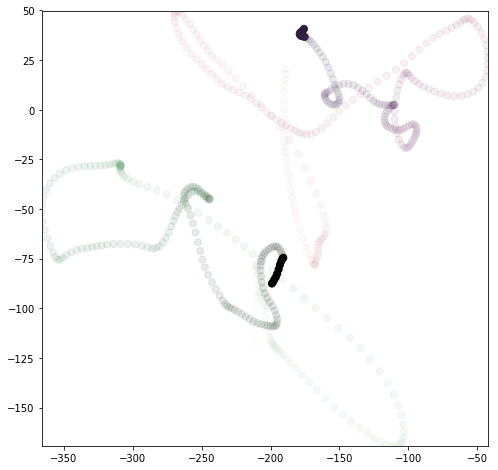

In [1005]:
# xdata = data[:, 0]
# ydata = data[:, 1]
print morph_level

a = AnimatedScatter(xdata=xdata, ydata=ydata, colors=np.array(calpha), 
                    npoints=2, nframes=nframes_per_trial+1, fps=50)
#a.show()

if fit_different:
    fit_str = 'fit_morphing'
else:
    fit_str = 'fit_all'
if subtract_grandmean:
    fit_str = '%s_subGM' % fit_str
    
movie_outpath = os.path.join(traceid_dir, 'figures', 'population', 'animation_%s_morph%i.mp4' % (fit_str, morph_level))

a.ani.save(movie_outpath)

#HTML(a.ani.to_jshtml())


In [986]:
morph_level

22

In [758]:
import copy

test_colors = copy.copy(curr_colors)
test_colors = [tuple(col) for col in test_colors]

In [759]:
test_colors[0:5]

[(0.9312692223325372, 0.8201921796082118, 0.7971480974663592),
 (0.9295025887390292, 0.8152326667362729, 0.7929166078664398),
 (0.9295025887390292, 0.8152326667362729, 0.7929166078664398),
 (0.9277259310503981, 0.8102681771847198, 0.7887391500236909),
 (0.9259384107157749, 0.8052992058997916, 0.7846153561731231)]

In [730]:
#Polar stuff
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111) #,polar=True)

#ax.set_title("A line plot on a polar axis", va='bottom')
#ax.set_rticks([0.5, 1, 1.5, 2])  # fewer radial ticks
#ax.set_facecolor(plt.cm.gray(.95))
#ax.grid(True)
#xT=plt.xticks()[0]
#xL=['0',r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$',\
#    r'$\pi$',r'$\frac{5\pi}{4}$',r'$\frac{3\pi}{2}$',r'$\frac{7\pi}{4}$']
#plt.xticks(xT, xL)
x = []
y = []
c = []

curr_colors = sns.cubehelix_palette(nframes_per_trial) #np.linspace(0, 1, )
for c in curr_colors:
    print c
    colors.append()
    
# Animation requirements.
ln, = plt.plot([], [], c=curr_colors[0],
                    marker = '.',
                    markersize=20,
                    alpha=1,
                    animated=True)

def init():
    ax.set_xlim(-1000, 1000)
    ax.set_ylim(-500, 500)
    return ln,

# def update(frame):
#     r.append(frame)
#     theta.append(5*np.pi*frame)
#     ln.set_data(theta, r)
#     return ln,
N=10
def update(frame):
    #print frame
    x.append(data[int(frame), 0])
    y.append(data[int(frame), 1])
    c.append(curr_colors[frame])
    print curr_colors[frame]
    ln.set_data(x[-N:], y[-N:])
    
    # check if line already exists, if yes make it gray:
#     if ln is not None:
#         ln.set_color('gray')
        
    # plot returns a list with line instances, one for each line you draw,
    # the comma is used to unpack the one element list
    ln.set_color(c[-N:])
    
    return ln,

ani = animation.FuncAnimation(fig, update, frames=range(nframes_per_trial),
                    init_func=init, interval=10, blit=True,repeat=True)
HTML(ani.to_jshtml())

plt.show()

movie_outpath = os.path.join(traceid_dir, 'figures', 'population', 'animation.mp4')
ani.save(movie_outpath)

[0.9312692223325372, 0.8201921796082118, 0.7971480974663592]


ValueError: Invalid RGBA argument: [[0.9312692223325372, 0.8201921796082118, 0.7971480974663592]]

ValueError: Invalid RGBA argument: [[0.9312692223325372, 0.8201921796082118, 0.7971480974663592]]

In [501]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

FLOOR = -10
CEILING = 10

class AnimatedScatter(object):
    def __init__(self, numpoints=5):
        self.numpoints = numpoints
        self.stream = self.data_stream()
        self.angle = 0

        self.fig = plt.figure()
        self.fig.canvas.mpl_connect('draw_event',self.forceUpdate)
        self.ax = self.fig.add_subplot(111,projection = '3d')
        self.ani = animation.FuncAnimation(self.fig, self.update, interval=100, 
                                       init_func=self.setup_plot, frames=20)

    def change_angle(self):
        self.angle = (self.angle + 1)%360

    def forceUpdate(self, event):
        self.scat.changed()

    def setup_plot(self):
        X = next(self.stream)
        c = ['b', 'r', 'g', 'y', 'm']
        self.scat = self.ax.scatter(X[:,0], X[:,1], X[:,2] , c=c, s=200)

        self.ax.set_xlim3d(FLOOR, CEILING)
        self.ax.set_ylim3d(FLOOR, CEILING)
        self.ax.set_zlim3d(FLOOR, CEILING)

        return self.scat,

    def data_stream(self):
        data = np.zeros(( self.numpoints , 3 ))
        xyz = data[:,:3]
        while True:
            xyz += 2 * (np.random.random(( self.numpoints,3)) - 0.5)
            yield data

    def update(self, i):
        data = next(self.stream)
        self.scat._offsets3d = ( np.ma.ravel(data[:,0]) , np.ma.ravel(data[:,1]) , np.ma.ravel(data[:,2]) )
        return self.scat,

    def show(self):
        plt.show()

# if __name__ == '__main__':
#     a = AnimatedScatter()
#     a.ani.save("movie.avi", codec='avi')
#     a.show()


In [509]:
pl.figure()
a = AnimatedScatter()
HTML(a.ani.to_jshtml())

movie_outpath = os.path.join(traceid_dir, 'figures', 'population', 'animation.avi')

#a.ani.save(movie_outpath, codec='avi')
a.show()

ValueError: Points must be Nx2 array, got 2x50

ValueError: Points must be Nx2 array, got 2x50

In [ ]:

plot_raw = False
dir1_color = 'magenta'
dir2_color = 'green'
dir1_label = 'dir %i' % dir1
dir2_label = 'dir %i' % dir2
    
fig, axes = pl.subplots(1, len(morph_levels), figsize=(20, 5), sharey=True)
for mi, morph_level in enumerate(sorted(morph_levels)):

    ax = axes[mi]
    
    grps1 = rdata_by_morph[morph_level][dir1].groupby('roi')
    mean_roi_traces1 = pd.concat([ pd.Series(grp[trial_cols].mean(axis=1), name=roi) for roi, grp in grps1 ], axis=1)

    grps2 = rdata_by_morph[morph_level][dir2].groupby('roi')
    mean_roi_traces2 = pd.concat([ pd.Series(grp[trial_cols].mean(axis=1), name=roi) for roi, grp in grps2 ], axis=1)
    
    
    #roidata1 = rdata_by_morph[morph_level][dir1][trial_cols]
    #roidata2 = rdata_by_morph[morph_level][dir2][trial_cols]
    #roidata1 = rdata1[rdata1['roi']==0]
    #roidata2 = rdata2[rdata2['roi']==0]
    popn_trace1 = mean_roi_traces1.mean(axis=1)
    popn_trace2 = mean_roi_traces2.mean(axis=1)

    mean_ppn_trace = (popn_trace1 + popn_trace2) / 2.

    # fig, ax = pl.subplots()
    meansub1 = []
    for roi in mean_roi_traces1.columns.tolist():
        values = mean_roi_traces1[roi] - mean_ppn_trace
        ax.plot(values, c=dir1_color, lw=0.1)
        meansub1.append(values)

    grand_mean1 = np.mean(np.array(meansub1), axis=0)
    #ax.plot(grandmean1, c=dir1_color, lw=2, label=dir1_label)

    
    
    meansub2 = []
    for roi in mean_roi_traces2.columns.tolist():
        values = mean_roi_traces2[roi] - mean_ppn_trace
        ax.plot(values, c=dir2_color, lw=0.1)
        meansub2.append(values)

    grand_mean2 = np.mean(np.array(meansub2), axis=0)
    #ax.plot(grand_mean2, c=dir2_color, lw=2, label=dir2_label)
    
    ax.set_title('morph %i' % morph_level)

sns.despine(trim=True, offset=8)
    

#### Plot the same, but subtract grand mean (all conditions)

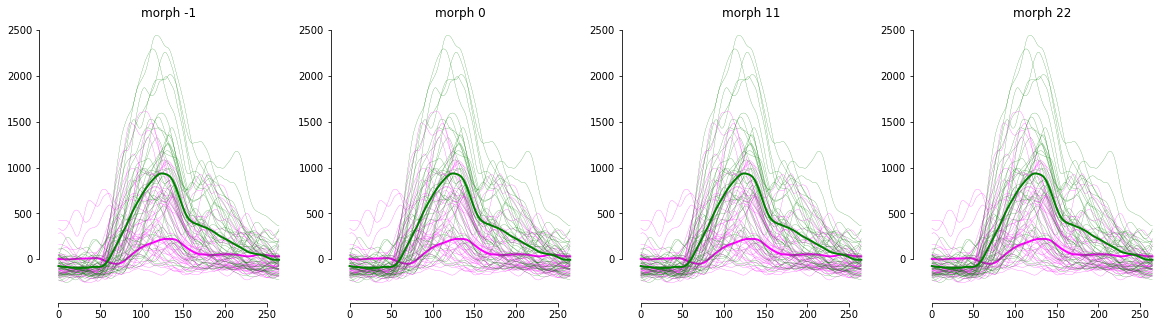

In [185]:
fig, axes = pl.subplots(1, len(morph_levels), figsize=(20, 5), sharey=True)
for mi, morph_level in enumerate(sorted(morph_levels)):

    ax = axes[mi]
    rdata1 = rdata_by_morph[morph_level][dir1]
    rdata2 = rdata_by_morph[morph_level][dir2]
    
    mean_trace = GM # (mean_trace1 + mean_trace2) / 2.

    meansub1 = []
    for tnum in roidata1.columns.tolist():
        if tnum == 'roi':
            continue
        values = roidata1[tnum].values - mean_trace
        ax.plot(values, c=dir1_color, lw=0.2)
        meansub1.append(values)

    grand_mean1 = np.mean(np.array(meansub1), axis=0)
    ax.plot(grandmean1*-1, c=dir1_color, lw=2, label=dir1_label)

    meansub2 = []
    for tnum in roidata2.columns.tolist():
        if tnum == 'roi':
            continue
        values = roidata2[tnum].values - mean_trace
        ax.plot(values, c=dir2_color, lw=0.2)
        meansub2.append(values)

    grand_mean2 = np.mean(np.array(meansub2), axis=0)
    ax.plot(grand_mean2, c=dir2_color, lw=2, label=dir2_label)
    
    ax.set_title('morph %i' % morph_level)

sns.despine(trim=True, offset=8)
    

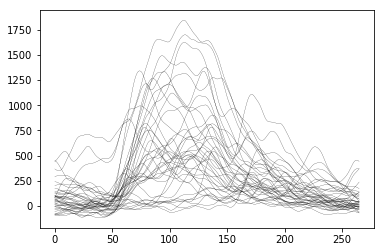

In [61]:
pl.figure()
for tnum in trialdf.columns.tolist():
    pl.plot(trialdf[tnum].values, 'k', lw=0.2)
    